# Sprint 8 · Webinar 26 · Data Analytics práctico

**Mini-proyecto:** Extracción de datos desde una **REST API** + **EDA básico** + **Correlación Pearson** + publicación en **GitHub**

> **Duración:** 100 minutos

Este notebook está diseñado para estudiantes que **nunca han trabajado con APIs**. Vamos paso a paso, con código corto y explicaciones claras.

## Fecha

> Completa aquí la fecha de la sesión.

## Objetivo de la sesión práctica (100 min)

Al finalizar esta clase podrás:

- Explicar qué es una **API REST** y cómo se consume con HTTP.
- Extraer datos desde una API pública y convertirlos a **pandas DataFrames**.
- Hacer un **EDA básico** (`info`, `describe`, conteo de nulos).
- Tratar **vacíos** (`""`) y **nulos** (`NaN`) con reglas simples.
- Calcular y analizar una **correlación Pearson** entre variables numéricas.
- Exportar resultados y subir el proyecto a **GitHub** con una estructura mínima.

## Agenda sugerida (100 minutos)

1. Introducción: ¿Qué es una API REST y para qué se usa? (10 min)
2. Ejercicio 1: Extraer datos desde una REST API (25 min)
3. Ejercicio 2: EDA básico con pandas (20 min)
4. Ejercicio 3: Vacíos y nulos (20 min)
5. Ejercicio 4: Correlación Pearson (15 min)
6. Ejercicio 5: Exportar + subir a GitHub (10 min)


## ¿Qué es una API REST?

Una **API** (*Application Programming Interface*) es una forma estándar para que un sistema le “ofrezca” datos o funciones a otro sistema.

Una **API REST** es un estilo común de APIs en la web. Normalmente funciona así:

- Tú (cliente) haces una **petición HTTP** a una URL (un **endpoint**)  
- El servidor responde con datos, muy frecuentemente en formato **JSON**  
- Tú procesas ese JSON (por ejemplo, con `pandas`) para analizarlo

### ¿Para qué se usan en Data Analytics?
En analítica, las APIs REST se usan para **extraer datos** desde sistemas externos, por ejemplo:
- CRMs (clientes), ERPs (ventas/inventario), plataformas de marketing, redes sociales, etc.
- Servicios de datos públicos (clima, economía, transporte, etc.)

### Conceptos mínimos
- **Endpoint:** la URL donde está el recurso (ej. `/users`, `/orders`)
- **Métodos HTTP:** `GET` (leer), `POST` (crear), `PUT/PATCH` (actualizar), `DELETE` (borrar)
- **Status codes:** `200` OK, `404` no encontrado, `500` error del servidor
- **Autenticación (común en APIs reales):** API keys, tokens (Bearer), OAuth

> En esta clase usaremos una API pública sin autenticación para enfocarnos en el flujo analítico.


## Setup del entorno

En esta sección importamos librerías y definimos funciones pequeñas para reutilizarlas.

**Regla en esta clase:** si un bloque de código se vuelve largo, lo partimos en celdas más pequeñas.

In [1]:
# Imports básicos
import json
from pathlib import Path

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt

---
# Ejercicio 1 · Extraer datos desde una REST API (25 min)

**Meta:** consumir una API pública y convertir el JSON en DataFrames.

Usaremos **JSONPlaceholder**, una API de prueba muy usada para aprender.
Nos interesan estos endpoints:

- `/users` (usuarios)
- `/posts` (publicaciones)
- `/comments` (comentarios)

> En un proyecto real, esta API podría ser un CRM/ERP. Aquí solo practicamos el proceso.

### 1.1 Función simple para hacer `GET` y manejar errores

Haremos una función `fetch_json(url)` para:

- Hacer la petición con `requests.get()`
- Verificar que la respuesta sea exitosa (`raise_for_status`)
- Retornar el JSON como lista/dict de Python

Además, guardaremos un **cache local** (archivo `.json`) para no descargar lo mismo cada vez.

In [2]:
BASE_URL = "https://jsonplaceholder.typicode.com"
CACHE_DIR = Path("data/raw")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def fetch_json(endpoint: str, cache_name: str):
    """Descarga JSON desde un endpoint y lo guarda en caché.

    Parámetros
    ----------
    endpoint : str
        Ruta del endpoint (por ejemplo: '/users').
    cache_name : str
        Nombre del archivo para cache (por ejemplo: 'users.json').

    Retorna
    -------
    data : list | dict
        Respuesta JSON convertida a objetos Python.
    """
    cache_path = CACHE_DIR / cache_name

    # 1) Si existe caché, lo leemos desde disco (más rápido)
    if cache_path.exists():
        with open(cache_path, "r", encoding="utf-8") as f:
            return json.load(f)

    # 2) Si no existe caché, descargamos desde la API
    url = f"{BASE_URL}{endpoint}"
    response = requests.get(url, timeout=30)
    response.raise_for_status()  # lanza error si status code no es 200-299

    data = response.json()

    # 3) Guardamos en caché
    with open(cache_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    return data

### 1.2 Descargar usuarios y convertir a DataFrame

Primero descargamos los usuarios (`/users`) y los convertimos a `pandas.DataFrame`.

In [3]:
users_json = fetch_json("/users", "users.json")
users = pd.json_normalize(users_json)

users.head()

,id,name,username,email,phone,website,address.street,address.suite,address.city,address.zipcode,address.geo.lat,address.geo.lng,company.name,company.catchPhrase,company.bs
0,1,Leanne Graham,Bret,Sincere@april.biz,1-770-736-8031 x56442,hildegard.org,Kulas Light,Apt. 556,Gwenborough,92998-3874,-37.3159,81.1496,Romaguera-Crona,Multi-layered client-server neural-net,harness real-time e-markets
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,010-692-6593 x09125,anastasia.net,Victor Plains,Suite 879,Wisokyburgh,90566-7771,-43.9509,-34.4618,Deckow-Crist,Proactive didactic contingency,synergize scalable supply-chains
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,1-463-123-4447,ramiro.info,Douglas Extension,Suite 847,McKenziehaven,59590-4157,-68.6102,-47.0653,Romaguera-Jacobson,Face to face bifurcated interface,e-enable strategic applications
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,493-170-9623 x156,kale.biz,Hoeger Mall,Apt. 692,South Elvis,53919-4257,29.4572,-164.2990,Robel-Corkery,Multi-tiered zero tolerance productivity,transition cutting-edge web services
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,(254)954-1289,demarco.info,Skiles Walks,Suite 351,Roscoeview,33263,-31.8129,62.5342,Keebler LLC,User-centric fault-tolerant solution,revolutionize end-to-end systems


### 1.3 Descargar posts y crear una tabla agregada por usuario

Descargamos `posts` y calculamos cuántos posts hizo cada usuario.

In [4]:
posts_json = fetch_json("/posts", "posts.json")
posts = pd.json_normalize(posts_json)

# Conteo de posts por usuario
posts_per_user = (
    posts.groupby("userId", as_index=False)
         .agg(posts_count=("id", "count"))
)

posts_per_user.head()

,userId,posts_count
0,1,10
1,2,10
2,3,10
3,4,10
4,5,10


### 1.4 Descargar comentarios y agregarlos por usuario

Los comentarios están relacionados con los posts. Vamos a:

1. Unir `comments` con `posts` para saber a qué usuario pertenece cada comentario
2. Agregar métricas por usuario: cantidad de comentarios y longitud promedio del texto

In [5]:
comments_json = fetch_json("/comments", "comments.json")
comments = pd.json_normalize(comments_json)

# Unimos comments con posts para conocer el userId de cada comentario
comments_with_user = comments.merge(
    posts[["id", "userId"]],
    left_on="postId",
    right_on="id",
    how="left"
).rename(columns={"userId": "userId_from_posts"})

# Métricas del texto del comentario (simple)
comments_with_user["comment_len"] = comments_with_user["body"].str.len()

comments_per_user = (
    comments_with_user.groupby("userId_from_posts", as_index=False)
    .agg(
        comments_count=("id_x", "count"),
        avg_comment_len=("comment_len", "mean")
    )
    .rename(columns={"userId_from_posts": "userId"})
)

comments_per_user.head()

,userId,comments_count,avg_comment_len
0,1,50,149.74
1,2,50,163.30
2,3,50,163.78
3,4,50,153.56
4,5,50,159.38


### 1.5 Construir el dataset analítico final

Ahora unimos todo en una sola tabla a nivel usuario.

**Idea analítica:** tendremos variables numéricas para explorar correlaciones.
Crearemos una métrica simple llamada `engagement_score`.

In [6]:
# Seleccionamos columnas útiles del usuario
users_small = users[["id", "name", "username", "email", "address.city", "company.name"]].copy()
users_small = users_small.rename(columns={
    "id": "userId",
    "address.city": "city",
    "company.name": "company"
})

# Unimos métricas de posts y comments
df = users_small.merge(posts_per_user, on="userId", how="left")
df = df.merge(comments_per_user, on="userId", how="left")

# Reemplazamos NaN por 0 en conteos (si algún usuario no tuviera datos)
df["posts_count"] = df["posts_count"].fillna(0).astype(int)
df["comments_count"] = df["comments_count"].fillna(0).astype(int)

# Engagement score simple (regla de negocio "de juguete")
df["engagement_score"] = df["posts_count"] + df["comments_count"]

df.head()

,userId,name,username,email,city,company,posts_count,comments_count,avg_comment_len,engagement_score
0,1,Leanne Graham,Bret,Sincere@april.biz,Gwenborough,Romaguera-Crona,10,50,149.74,60
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,Wisokyburgh,Deckow-Crist,10,50,163.30,60
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,McKenziehaven,Romaguera-Jacobson,10,50,163.78,60
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,South Elvis,Robel-Corkery,10,50,153.56,60
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,Roscoeview,Keebler LLC,10,50,159.38,60


---
# Ejercicio 2 · EDA básico con pandas (20 min)

**Meta:** entender rápidamente el dataset con funciones estándar.

Haremos:
- Tamaño del dataset (`shape`)
- Tipos de dato y nulos (`info`)
- Estadísticos básicos (`describe`)

In [7]:
df.shape

(10, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userId            10 non-null     int64  
 1   name              10 non-null     object 
 2   username          10 non-null     object 
 3   email             10 non-null     object 
 4   city              10 non-null     object 
 5   company           10 non-null     object 
 6   posts_count       10 non-null     int64  
 7   comments_count    10 non-null     int64  
 8   avg_comment_len   10 non-null     float64
 9   engagement_score  10 non-null     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 932.0+ bytes


In [9]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userId,10.0,NaN,NaN,NaN,5.5,3.02765,1.0,3.25,5.5,7.75,10.0
name,10,10,Leanne Graham,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
username,10,10,Bret,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email,10,10,Sincere@april.biz,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,10,10,Gwenborough,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company,10,10,Romaguera-Crona,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
posts_count,10.0,NaN,NaN,NaN,10.0,0.0,10.0,10.0,10.0,10.0,10.0
comments_count,10.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
avg_comment_len,10.0,NaN,NaN,NaN,161.528,5.860165,149.74,159.95,163.54,164.44,169.1
engagement_score,10.0,NaN,NaN,NaN,60.0,0.0,60.0,60.0,60.0,60.0,60.0


---
# Ejercicio 3 · Vacíos y nulos (20 min)

**Meta:** identificar, estandarizar y tratar datos faltantes.

En la vida real, los datos casi siempre tienen problemas:

- `NaN` (nulo real)
- `""` (vacío, string)
- valores “raros” como `0` cuando debería existir un valor

> La API de prueba viene bastante limpia, así que vamos a **simular** algunos problemas para aprender.

### 3.1 Simular vacíos/nulos (solo para la práctica)

Crearemos algunos vacíos en columnas de texto y algunos nulos en columnas numéricas.

In [10]:
df_dirty = df.copy()

# Semilla para reproducibilidad
np.random.seed(7)

# 1) Simulamos emails vacíos en ~20% de filas
mask_email = np.random.rand(len(df_dirty)) < 0.2
df_dirty.loc[mask_email, "email"] = ""

# 2) Simulamos city como nulo en ~10% de filas
mask_city = np.random.rand(len(df_dirty)) < 0.1
df_dirty.loc[mask_city, "city"] = np.nan

# 3) Simulamos avg_comment_len nulo en ~15% de filas
mask_avg = np.random.rand(len(df_dirty)) < 0.15
df_dirty.loc[mask_avg, "avg_comment_len"] = np.nan

df_dirty.head()

,userId,name,username,email,city,company,posts_count,comments_count,avg_comment_len,engagement_score
0,1,Leanne Graham,Bret,,Gwenborough,Romaguera-Crona,10,50,149.74,60
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,Wisokyburgh,Deckow-Crist,10,50,163.30,60
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,McKenziehaven,Romaguera-Jacobson,10,50,163.78,60
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,NaN,Robel-Corkery,10,50,153.56,60
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,Roscoeview,Keebler LLC,10,50,159.38,60


### 3.2 Detectar nulos (`NaN`) y vacíos (`""`)

Primero contamos nulos por columna y luego contamos vacíos en columnas de texto.

In [11]:
# Conteo de nulos por columna
nulls_per_col = df_dirty.isna().sum().sort_values(ascending=False)

# Conteo de vacíos por columna de texto
empty_email = (df_dirty["email"] == "").sum()

nulls_per_col, empty_email

(city                2
 avg_comment_len     1
 name                0
 userId              0
 email               0
 username            0
 company             0
 posts_count         0
 comments_count      0
 engagement_score    0
 dtype: int64,
 np.int64(2))

### 3.3 Estandarizar vacíos → nulos

Una práctica común es convertir `""` a `NaN` para tratar todo como “faltante”.

In [12]:
df_clean = df_dirty.copy()

# Convertimos strings vacíos a NaN en columnas de texto que nos interesan
df_clean["email"] = df_clean["email"].replace("", np.nan)

df_clean[["email"]].head()

,email
0,NaN
1,Shanna@melissa.tv
2,Nathan@yesenia.net
3,Julianne.OConner@kory.org
4,Lucio_Hettinger@annie.ca


### 3.4 Tratar faltantes con reglas simples

Estrategias básicas:

- **Numéricas:** reemplazar por la **mediana** (robusta a outliers)
- **Categóricas/texto:** reemplazar por una etiqueta como **"desconocido"**

> En proyectos reales puedes usar métodos más avanzados, pero aquí buscamos claridad.

In [13]:
# 1) Imputación de texto
df_clean["email"] = df_clean["email"].fillna("desconocido")
df_clean["city"] = df_clean["city"].fillna("desconocido")

# 2) Imputación numérica (mediana)
median_avg_len = df_clean["avg_comment_len"].median()
df_clean["avg_comment_len"] = df_clean["avg_comment_len"].fillna(median_avg_len)

# Verificamos que ya no hay nulos
df_clean.isna().sum()

userId              0
name                0
username            0
email               0
city                0
company             0
posts_count         0
comments_count      0
avg_comment_len     0
engagement_score    0
dtype: int64

---
# Ejercicio 4 · Correlación Pearson (15 min)

La **correlación Pearson** mide qué tan relacionada está una variable numérica con otra (relación **lineal**).

- Va de **-1** a **1**
- Cerca de **1**: relación positiva fuerte
- Cerca de **-1**: relación negativa fuerte
- Cerca de **0**: poca relación lineal

**Importante:** correlación ≠ causalidad.

In [14]:
# Seleccionamos solo columnas numéricas para Pearson
num_cols = ["posts_count", "comments_count", "avg_comment_len", "engagement_score"]
corr = df_clean[num_cols].corr(method="pearson")

corr

,posts_count,comments_count,avg_comment_len,engagement_score
posts_count,NaN,NaN,NaN,NaN
comments_count,NaN,NaN,NaN,NaN
avg_comment_len,NaN,NaN,1.0,NaN
engagement_score,NaN,NaN,NaN,NaN


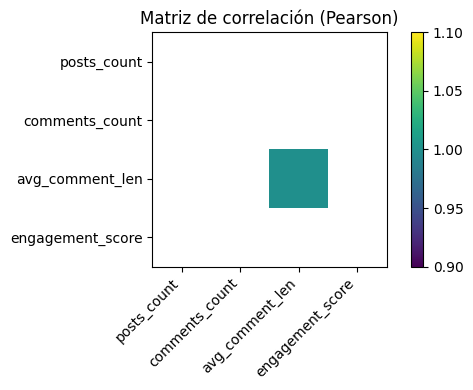

In [15]:
# Heatmap simple con matplotlib (sin estilos avanzados)
plt.figure(figsize=(6, 4))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Matriz de correlación (Pearson)")
plt.tight_layout()
plt.show()

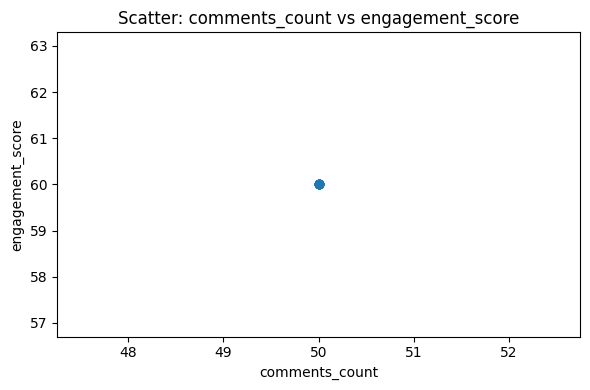

In [16]:
# Ejemplo: relación entre comments_count y engagement_score
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["comments_count"], df_clean["engagement_score"])
plt.xlabel("comments_count")
plt.ylabel("engagement_score")
plt.title("Scatter: comments_count vs engagement_score")
plt.tight_layout()
plt.show()

---
# Ejercicio 5 · Exportar resultados y publicar en GitHub (10 min)

**Meta:** guardar el dataset limpio y dejar el proyecto listo para subir a GitHub.

Estructura mínima recomendada:

```
mi-proyecto-api-eda/
  data/
    raw/
    processed/
  notebooks/
  README.md
  requirements.txt
  .gitignore
```

> En esta clase guardaremos los CSV en `data/processed/`.

In [17]:
# Creamos carpeta de salida
processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# Exportamos dataset final limpio
output_path = processed_dir / "users_api_eda_clean.csv"
df_clean.to_csv(output_path, index=False)

output_path

WindowsPath('data/processed/users_api_eda_clean.csv')

## Paso a paso para subir a GitHub

1) Crea un repositorio en GitHub (sin subir archivos aún)

2) En tu computador, abre una terminal en la carpeta del proyecto y ejecuta:

```bash
git init
git add .
git commit -m "Proyecto: extracción REST API + EDA"
git branch -M main
git remote add origin <URL_DE_TU_REPO>
git push -u origin main
```

3) (Opcional) Crea un archivo `requirements.txt`:

```bash
pip freeze > requirements.txt
```

4) Checklist de entrega típica:
- Notebook corre sin errores (reiniciar kernel y ejecutar todo)
- CSV exportado en `data/processed/`
- README con descripción, pasos y resultados


---
# Cierre · Takeaways

- Una API REST se consume con HTTP (frecuente formato JSON).
- `pandas` permite convertir JSON en DataFrames y analizar rápidamente.
- Distingue entre **vacíos** (`""`) y **nulos** (`NaN`).
- Pearson sirve para explorar relaciones lineales entre numéricas.
- Publicar en GitHub = portafolio + reproducibilidad.